In [4]:
# preparation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from prml.preprocess import PolynomialFeature
from prml.linear import (
    BayesianLogisticRegression,
    LeastSquaresClassifier,
    FishersLinearDiscriminant,
    LogisticRegression,
    Perceptron,
    SoftmaxRegression
)

np.random.seed(1234)

In [5]:
# data
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1, 2) - 1
    x1 = np.random.normal(size=50).reshape(-1, 2) + 1.
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1, 2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 3.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(np.int)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

前一章中，我们研究了一类有相当简单的解析和计算性质的回归模型。现在，我们讨论一类与此相似的用于解决分类问题的模型。分类的目的是是将输入变量$ x $分到$ K $个离散的类别$ C_k,k=1,...K $中的一类。一般情况下，类别是互不相交的，因此每个输入被分到唯一的一个类别中。输入空间被决策边界（decision boundary）或决策面（decision surface）划分成不同的决策区域（decision region）。本章，我们考虑线性分类模 型。所谓线性分类模型是指决策面是输入向量$ x $的线性函数，因此它定义了**$ D $维输入空间中的$ (D − 1) $维超平面**。如果数据集可以被线性决策面精确地分类，那么我们说这个数据集是线性可分的（linearly separable）。

对于回归问题，我们希望预测的变量$ t $是一个实数向量。在分类问题中，有很多不同的方式来表达目标变量的标签。对于概率模型，二分类问题最方便的表达方式是二元表示方法。这种方法中，目标变量$ t \in {0, 1} $，其中$ t = 1 $表示类别$ C_1 $，而$ t = 0 $表示类别$ C_2 $。我们可以把$ t $的值解释为分类结果为$ C_1 $的概率，其中概率只取极限值$ 0, 1 $。对于$ K > 2 $的情况，比较方便的方法是使用“1-of-K”编码规则。这种方法是：$ t $是一个长度为$ K $的向量。如果类别为$ C_j $，那么$ t $的所有元素$ t_k $，除了$ t_j $等于1，其余的都等于0。例如，如果我们有5个类别，那么来自第2个类别的模式给出的目标向量为

$ t = (0,1,0,0,0)^T \tag{4.1} $

同样的，我们也可以把$ t_k $的值解释为分类为$ C_k $的概率。对于非概率模型，目标变量使用其它表示方法有时候会更方便。

在第1章，我们提出了三种不同的解决分类问题的方法。**最简单的方法是构造一个直接把向量$ x $分到具体的类别中判别函数（discriminant function）**。

但是，**一个更强大的方法是在推断阶段对条件概率分布$ p(C_k|x) $进行建模，然后使用这个概率分布进行最优决策**。正如1.5.4节讨论的那样，分离推断和决策两个阶段，可以获得了很多有益的东西。有两种不同的方法来确定条件概率$ p(C_k|x) $。**一种是直接对它建模，例如把条件概率分布表示为参数模型，然后使用训练集来最优化参数**。**另一种是生成式的方法。在这种方法中，我们对类条件概率密度$ p(x|C_k) $以及先验概率分布$ p(C_k) $建模，然后使用贝叶斯定理来计算需要的后验概率分布**
$ p(C_k|x) = \frac{p(x|C_k)p(C_k)}{p(x)} \tag{4.2} $
我们将在本章中讨论这三种方法的例子。

在第3章讨论的线性回归模型中，模型的预测$ y(x,w) $是由参数$ w $的线性函数给出的。在最简单的情况下，模型对输入变量也是线性的，因此形式为$ y(x) = w^Tx + w_0 $，即$ y $是一个实数。然而对于分类问题，我们想预测的是离散的类别标签，或更一般地，预测位于区间$ (0, 1) $的后验概 率。为了达到这个目的，我们考虑使用非线性函数$ f(\dot) $对$ w $的线性函数进行变换，来推广这个模型，即
$ y(x) = f(w^Tx + w_0) \tag{4.3} $
在机器学习的文献中$ f(\dot) $被称为**激活函数（activation function）**，而它的反函数在统计文献中被称为链接函数（link function）。决策面对应于$ y(x) = constant $，即$ w^T x + w_0 = constant $，因此决策面是$ x $的线性函数，即使函数$ f(\dot) $为非线性函数也是如此。因此，由式（4.3）描述的这一类模型被称为广义线性模型（generalized linear model）（McCullagh and Nelder, 1989）。但是，需要注意，与回归中使用的模型相反，引入了**非线性**函数$ f(\dot) $后，它们不再是关于参数线性的。这会导致比线性回归模型更加复杂的分析及计算。尽管这样，这些模型仍然比后续章节中讨论的更加一般的非线性模型来得简单。
本章中讨论的算法，在使用一个基函数$ \phi(x) $向量（就像第3章的回归模型中那样），对输入变量进行固定的非线性变换的情况下同样适用。我们以直接在原始输入空间$ x $进行分类作为本章的开始。而第4.3章中，为了与后续章节的一致性，我们发现引入基函数会比较方便。



## 4.1 判别函数
判别式是一个使用输入向量$ x $并把它分配给$ K $种分类的其中一种$ C_k $的函数。本章中，我们把我们的讨论局限于线性判别式（linear discriminants），即那些决策面是超平面的判别函数。为了简化讨论，我们首先考虑二分类的情况，再推广到$ K > 2 $的情形。

## 4.1.1 二分类

线性判别式的最简单形式是取输入向量的线性函数，即
$ y(x) = w^Tx + w_0 \tag{4.4} $
其中$ w $被称为**权向量（weight vector），$ w_0 $是偏置（不要与统计中的偏置混淆3.1节也讲过这句话：估计量的期望值与估计量的真实值之差）**。**偏置的相反数有时被称为阈值（threshold）**。如果$ y(x) \geq 0 $则把输入向量$ x $分到类$ C_1 $中，否则分到$ C_2 $中。因此，对应的决策边界由$ y(x) = 0 $确定，它对应着$ D $维空间中的一个$ (D-1) $维超平面。考虑两个点$ x_A, x_B $都处在超平面上的情形。由于$ y(x_A) = y(x_B) = 0 $，得到$ w^T(x_A - x_B) = 0 $，所以**向量$ w $与在决策面上的所有向量都正交，因此$ w $确定了决策面的方向**。同样的，如果$ x $在决策面，那么$ y(x) = 0 $，所以原点到决策面的标准距离由
$ \frac{w^Tx}{\Vert w \Vert} = -\frac{w_0}{\Vert w \Vert} \tag{4.5} $


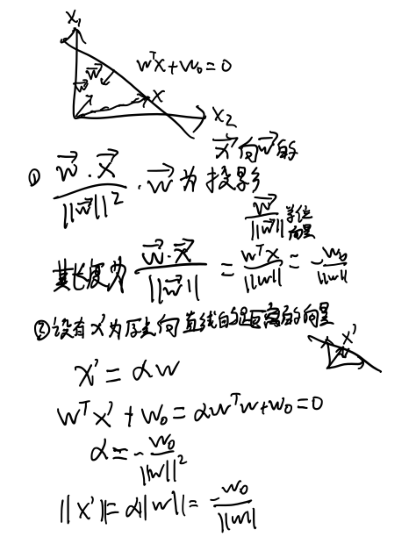

In [7]:
# 4.5推导
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/4.5推导.png')
plt.axis('off')
ax.imshow(d)

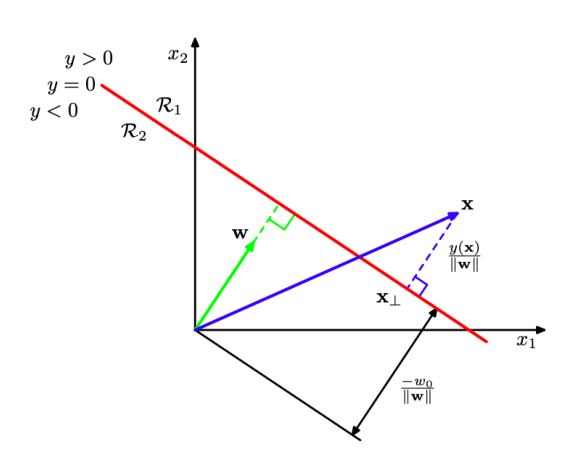

In [8]:
# 图4.1
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图4.1.png')
plt.axis('off')
ax.imshow(d)


所以我们看到偏置参数$ w_0 $确定了决策面的位置。图4.1阐释了$ D = 2 $情况下的这些性质。 
此外，我们注意到$ y(x) $的值给出了点$ x $到决策面的垂直距离$ r $的一个有符号的度量。为了证明这点，考虑任意点$ x $并令$ x_{\perp} $是它在决策面上的正交投影，即
$ x = x_{\perp} + r\frac{w}{\Vert w \Vert} \tag{4.6} $
两边同时乘以$ w^T $并加上$ w_0 $，再利用$ y(x)=w^Tx+w_0, y(x_{\perp})=w^Tx_{\perp} + w_0 = 0 $得到
$ r = \frac{y(x)}{\Vert w \Vert} \tag{4.7} $
图4.1阐释的这个结果。

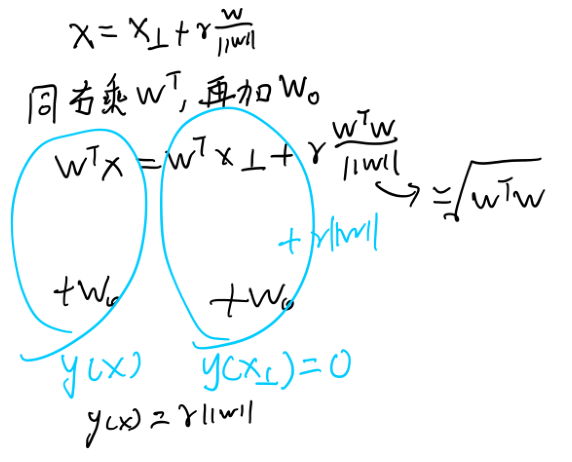

In [9]:
# 4.7推导
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/4.7推导.png')
plt.axis('off')
ax.imshow(d)


与第3章线性回归模型相同，有时引入一个额外的虚“输入”$ x_0 = 1 $来使记号更简洁，会比较方便。然后定义$ \tilde{w} = (w_0, w) \tilde{x} = (x_0, x) $，然后
$ y(x) = \tilde{w}^T\tilde{x} \tag{4.8} $
在这种情况下，**决策面是一个穿过$ D+1 $维扩展输入空间原点的$ D $维超平面**。



参考资料： https://math.stackexchange.com/questions/1029153/deriving-the-normal-distance-from-the-origin-to-the-decision-surface

## 4.1.2 多分类

现在把线性判别式推广到$ K > 2 $个类别的情况，我们可能会尝试组合多个二分类判别式来构造一个$ K $类判别式。然而这会导致一些现在要展示的严重问题（Duda and Hart, 1973）。

**考虑一个包含$ K-1 $个把属于类别$ C_k $的点与其它的区分开的分类器(本类和其他类)**。这被称为一对其他（one-versus-the-rest）分类器。图4.2的左手边展示了一个涉及三个类别的例子，这种方法会导致空间中有一块类别含糊不清的区域。

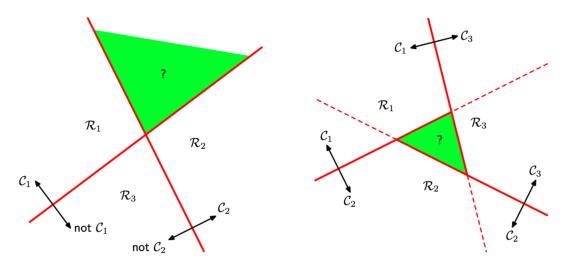

In [10]:
# 图4.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图4.2.png')
plt.axis('off')
ax.imshow(d)

另一种方法是引入$ K(K-1)/2 $个二元判别函数，对**每一对类别都设置一个**。这被称为一对一（one-versus-one）分类器。然后根据这些判别函数的大多数投票来确定每个点的类别。然而这也会引起类别含糊不清的区域的问题，图4.2的右手边展示。


所以，引入包含$ K $个形式为
$ y_k(x) = w_k^Tx + w_{k0} \tag{4.9} $
的线性函数的单个$ K $类判别式，并把点$ x $分入对于所有$ j \neq k $都有$ y_k(x) > y_j(x) $的类$ C_k $中，就可以避免这些问题。类$ C_k, C_j $间的决策边界由$ y_k(x) = y_j(x) $给出，它对应形式为
$ (w_k - w_j)^Tx + (w_{k0} - w_{j0}) = 0 \tag{4.10} $
的$ (D-1) $维的超平面。这与4.1.1节讨论的二分类情况下的决策边界具有相同的形式，因此也有类似的几何性质。

这样的判别式得到的决策区域总是**单连通且凸的**。为了证明这个，让我们考虑图4.3中展示的，两个都位于决策区域$ R_k $中的点$ x_A,x_B $。

任何一个在连接$ x_A,x_B $线段上的点$ \hat{x} $可以表示为
$ \hat{x}=\lambda x_A + (1-\lambda)x_B \tag{4.11} $
其中$ 0 \leq \lambda \leq 1 $。根据判别函数的线性性，可以得到
$ y_k(\hat{x}) = \lambda y_k(x_A) + (1-\lambda)y_k(x_B) \tag{4.12} $
因为$ x_A, x_B $都在$ R_k $中，所以对于所有$ j \neq k $都满足$ y_k(x_A) > y_j(x_A), y_k(x_B) > y_j(x_B) $，所以$ y_k(\hat{x}) > y_j(\hat{x}) $，所以$ \bar{x} $在$ R_k $中。因此$ R_k $是单连通且凸的(**我理解是如果两个点都属于第k类，它们之间的点也都是属于k类别**)。
注意，对于二分类的情形，我们既可以使用这里讨论的基于两个判别函数$ y_1(x), y_2(x) $方法，也可以使用4.1.1节给出基于单一的判别函数$ y(x) $的更简单的但等价的方法。

现在，我们开始探讨三种线性判别函数的参数学习方法，即基于**最小二乘、Fisher线性判别式，以及感知器算法**。

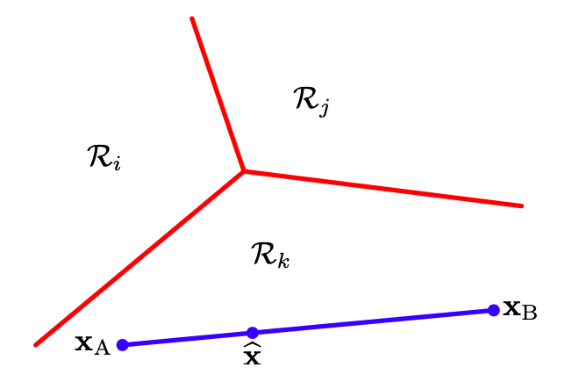

In [11]:
# 图4.3
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图4.3.png')
plt.axis('off')
ax.imshow(d)

## 4.1.3 用于分类的最小平方法

在第3章中，我们考虑了参数线性函数的模型，并看到通过最小化平方误差函数可以得到参数的简单解析解。因此我们想尝试在分类问题中是否也可以使用这种方法。考虑一个一般的使用“1-of-K”编码规则的目标向量的$ K $类别分类问题。在这样的背景下，使用最小二乘的一个理由是对于规定输入向量，它近似目标值的条件期望$ \mathbb{E}[t|x] $。对于二元编码模式，这个条件期望是由后验类概率向量给出的。不幸的是，这些概率通常很难近似。事实上，正如我们稍后要讨论的那样，由于线性模型的灵活性很受限，近似的过程有可能产生位于区间$ (0, 1) $之外的值。
每个类别$ C_k $通过它自己的线性模型
$ y_k(x) = w_k^Tx + w_{k0} \tag{4.13} $
来描述的，其中$ k=1,...,K $。可以很容易地把这些量聚集在一起表示，即
$ y(x) = \widetilde{W}^T\tilde{x} \tag{4.14} $
其中$ \widetilde{W} $是第$ k^{th} $列构成$ D+1 $维向量$ \tilde{w}k = (w_{k0}, w_k^T)^T $的矩阵，$ \tilde{x} $对应的是通过虚输入$ x_0=1 $扩张后的输入向量$ (1,x^T)^T $。这个表示方法已经在3.1节详细讨论过。然后，一个新的输入$ x $被分配到输出$ y_k = \tilde{w}_k^T\tilde{x} $最大的类别中。

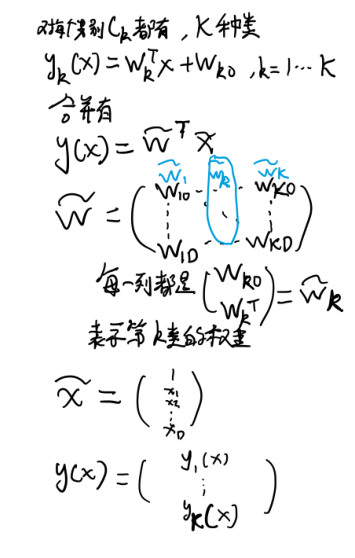

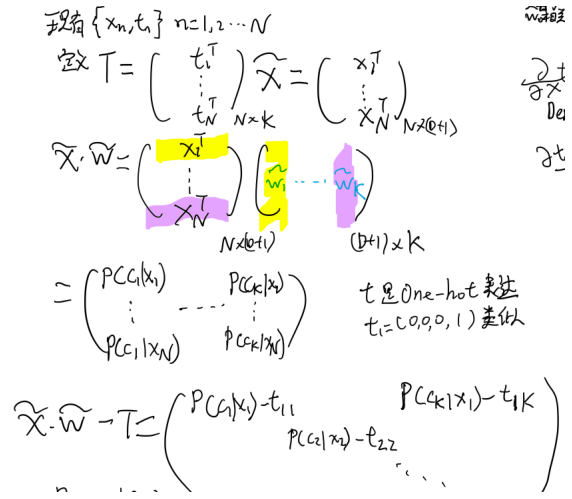

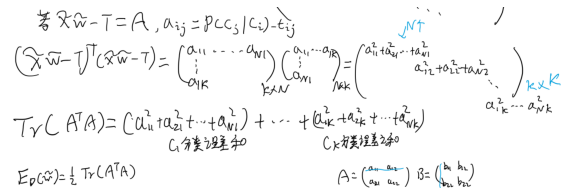

In [15]:
# 4.15
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/4.15up.png')
plt.axis('off')
ax.imshow(d)

fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/4.15middle.png')
plt.axis('off')
ax.imshow(d)

fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/4.15down.png')
plt.axis('off')
ax.imshow(d)

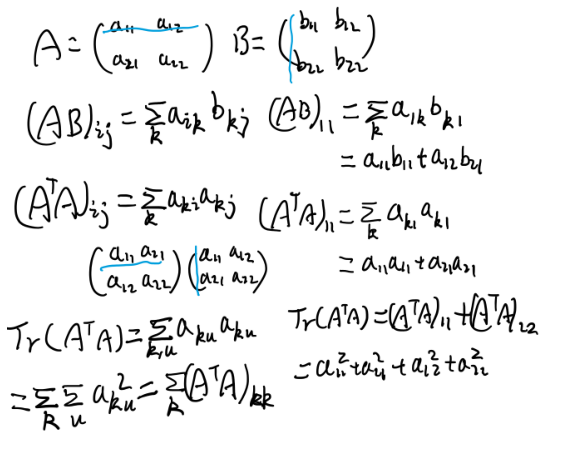

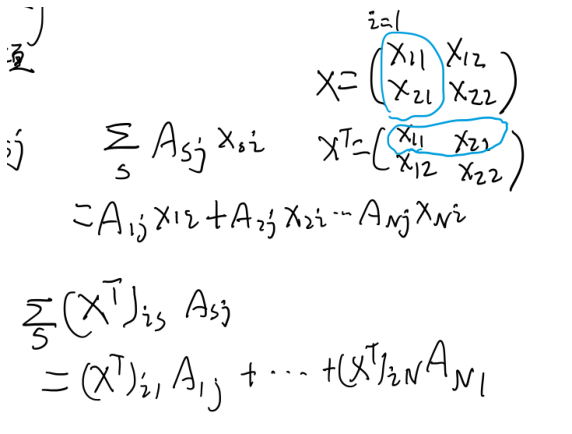

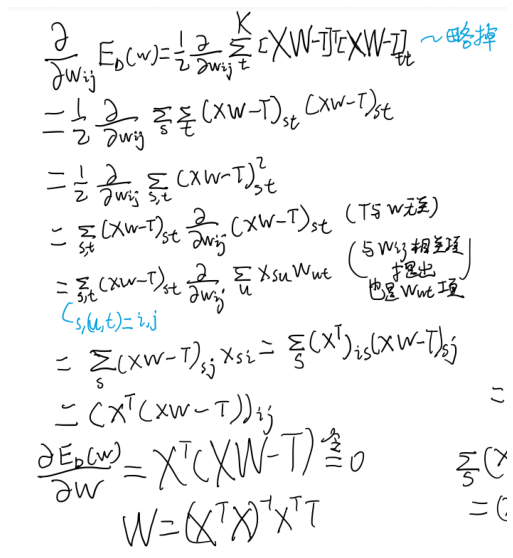

In [17]:
# 4.16
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/4.16up.png')
plt.axis('off')
ax.imshow(d)

fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/4.16middle.png')
plt.axis('off')
ax.imshow(d)

fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/4.16down.png')
plt.axis('off')
ax.imshow(d)


现在，就像我们在第3章中的回归一样，通过最小化平方和误差函数来确定参数矩阵$ \widetilde{W} $。考虑一个训练数据集$ {x_n,t_n} n = 1,...,N $，然后定义一个第$ n^{th} $行是向量$ t_n^T $矩阵$ T $，和第$ n^{th} $行是$ \tilde{x}_n^T $的矩阵$ \tilde{X} $。然后，平方和误差函数就可以写成
$$
E_{D}(\tilde{\boldsymbol{W}})=\frac{1}{2} \operatorname{Tr}\left\{(\tilde{\boldsymbol{X}} \tilde{\boldsymbol{W}}-\boldsymbol{T})^{T}(\tilde{\boldsymbol{X}} \tilde{\boldsymbol{W}}-\boldsymbol{T})\right\}\tag{4.15} $$
令关于$ \widetilde{W} $的导数等于零，整理，可得$ \widetilde{W} $的解
$ \widetilde{W} = (\tilde{X}^T\tilde{X})^{-1}\tilde{X}^TT=\tilde{X}^+T \tag{4.16} $
其中$ \tilde{X}^+ $是3.1.1节中讨论过的$ \tilde{X} $的伪逆。然后我们得到形式为
$ y(x) = \widetilde{W}^T\tilde{x} = T^T\left(\tilde{X}^+\right)^T\tilde{x} \tag{4.17} $
的判别函数。


多目标变量的最小二乘解的一个有趣性质是，如果训练集合中的每个目标向量对于某些常数$ a, b $都满足线性约束
$ a^Tt_n + b = 0 \tag{4.18} $
那么，模型对于任意的$ x $值预测也满足这个约束，即
$ a^Ty(x) + b = 0 \tag{4.19} $


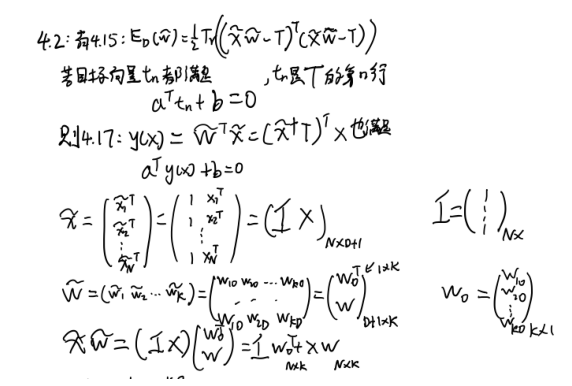

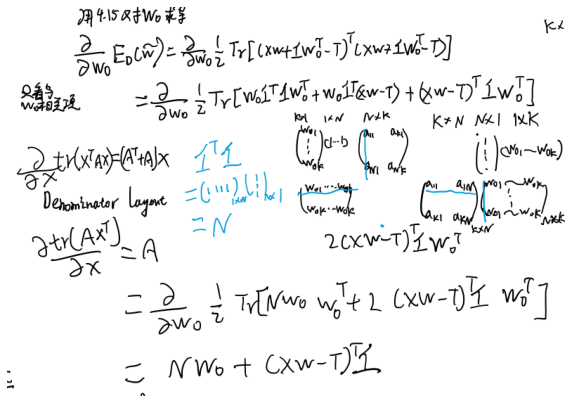

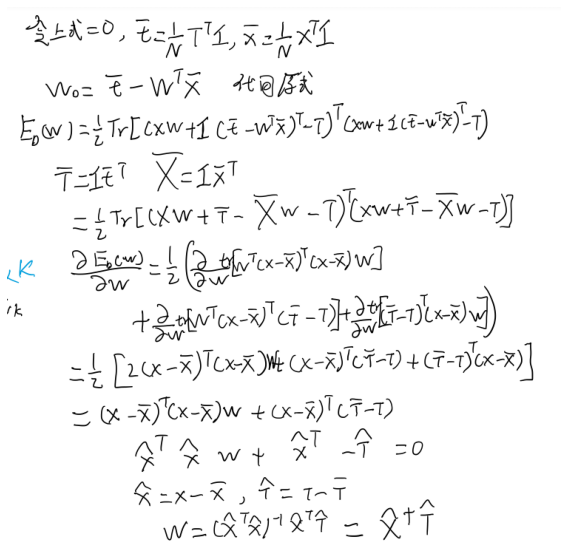

In [22]:
# 习题4.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/习题4.2up.png')
plt.axis('off')
ax.imshow(d)

fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/习题4.2middle.png')
plt.axis('off')
ax.imshow(d)

fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/习题4.2down.png')
plt.axis('off')
ax.imshow(d)

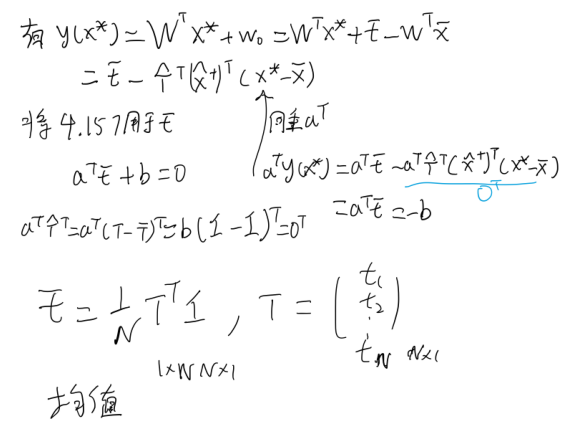

In [23]:
# 习题4.2last
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/习题4.2last.png')
plt.axis('off')
ax.imshow(d)

因此，如果我们对$ K $个分类使用“1-of-K”编码模式，那么模型对任意的$ x $值所做的预测$ y(x) $的元素的和都是1。但是，由于模型的输出没有限制在区间$ (0, 1) $中，所以这个和的限制并不能让它具有概率的解释。
最小二乘法给出了判别函数的参数的精确解析解。然而，即使作为判别函数（丢掉所有的概率解释直接进行预测）它依然有非常严重的问题。**我们已经看到最小二乘解对于离群点缺乏鲁棒性**，这对分类问题也是一样的，如图4.4所示。

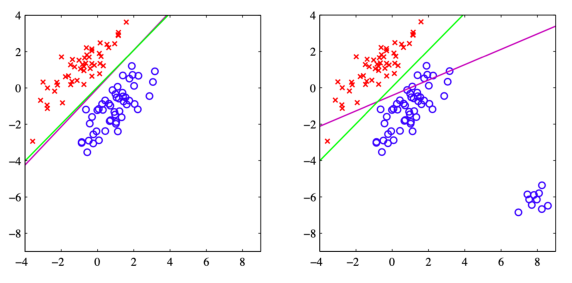

In [24]:
# 图4.4
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图4.4.png')
plt.axis('off')
ax.imshow(d)

这里，我们看到，右图中的额外的数据点极大的改变了决策边界的位置，即使这些点能够被左图中的原始的决策边界正确地分类。平方和误差函数会惩罚那些虽然在决策边界正确的一侧但距离很远的那些“过于正确”的预测。在7.1.2节中，我们将讨论一些其他的不会有这种问题的误差函数。
然而，如图4.5所示，最小二乘问题会有比缺乏鲁棒性验证的多的问题。

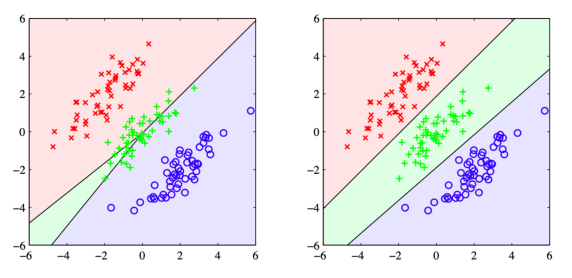

In [25]:
# 图4.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图4.5.png')
plt.axis('off')
ax.imshow(d)

这幅图展示了从二维输入空间$ (x_1, x_2) $中，人工生成的线性决策边界能够将数据点完美地分开的，三个类别的数据的集合。实际上，在本章的后面介绍的logistic回归方法也可以给出满意的解，如右图所示。然而，最小二乘法给出的结果相当差，输入空间中只有一个相当小的区域被分给了绿色的类别。
由于最小二乘对应的是高斯条件分布假设下的最大似然，而二元目标向量分布显然和高斯分布差距比较大，所以我们并不会对它的失败感到惊讶。通过使用更恰当的概率模型，我们会得到性质比最小二乘更好的分类方法。但是现在，我们继续探索其它的非概率方法来设置线性分类模型中的参数。

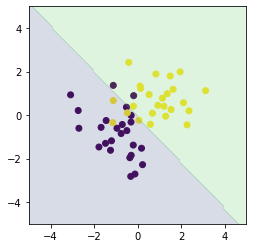

In [4]:
# 二分类
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = LeastSquaresClassifier()
model.fit(X_train, y_train)
y = model.classify(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

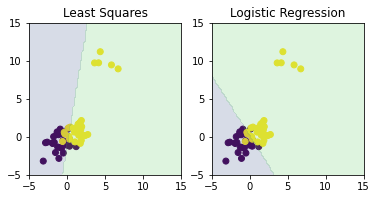

In [16]:
# 三分类
x_train, y_train = create_toy_data(add_outliers=True)
x1_test, x2_test = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

least_squares = LeastSquaresClassifier()
least_squares.fit(X_train, y_train)
y_ls = least_squares.classify(X_test)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_lr = logistic_regression.classify(X_test)

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_ls.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Least Squares")
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_lr.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Logistic Regression")
plt.show()

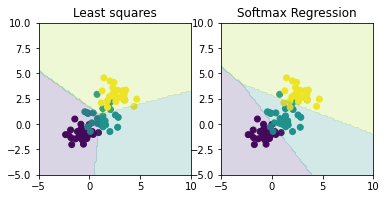

In [6]:
# 三分类
x_train, y_train = create_toy_data(add_class=True)
x1_test, x2_test = np.meshgrid(np.linspace(-5, 10, 100), np.linspace(-5, 10, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

least_squares = LeastSquaresClassifier()
least_squares.fit(X_train, y_train)
y_ls = least_squares.classify(X_test)

logistic_regression = SoftmaxRegression()
logistic_regression.fit(X_train, y_train, max_iter=1000, learning_rate=0.01)
y_lr = logistic_regression.classify(X_test)

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_ls.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Least squares")
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_lr.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Softmax Regression")
plt.show()

参考资料：https://qiita.com/yosshun/items/45ee5ed91f3569c59fac

## 4.1.4 Fisher线性判别函数

我们可以从降维的角度来观察线性分类模型。首先考虑二分类的情形，并假设有$ D $维输入向量$ x $并使用
$ y=w^Tx \tag{4.20} $
把它投影到一维空间。如果我们在$ y $上放一个阈值，并把$ y \geq -w_0 $分到类别$ C_1 $中，其余的分到类别$ C_2 $，那么我们就得到了前一小节讨论的标准的线性分类器。通常来说，投影在一维空间会造成大程度的信息损失，所以能够在原来的$ D $维空间中完全分开的样本在一维空间中可能会相互重叠。不过通过调节分量的权向量$ w $，我们可以选择使类别最分散的一个投影。首先，考虑一个包含$ N_1 $个$ C_1 $点和$ N_2 $个$ C_2 $点的二分类问题，那么两个类别的均值向量为：
$ m_1 = \frac{1}{N_1}\sum\limits_{n \in C_1}x_n , m_2 = \frac{1}{N_2}\sum\limits_{n \in C_2}x_n \tag{4.21} $
当投影到$ w $上后，最简单的度量类别之间分开程度的方法就是投影之后的的类别均值的距离。这要求我们去选择那个使得
$ m_2-m_1 = w^T(m_2 - m_1) \tag{4.22} $
最大的$ w $的值。 其中
$ m_k = w^Tm_k \tag{4.23} $
类别$ C_k $的数据投影后的均值。但是，可以通过增大$ w $来使这个表达式无穷大。为了解决这个问题，我们现在$ w $为单位长的，即$ \sum_i w_i^2 = 1 $。使用拉格朗日乘数法来求解限制条件下的最大化问题，得到$ w \propto (m_2 - m_1) $。但是这个方法还有图4.6展示的问题。


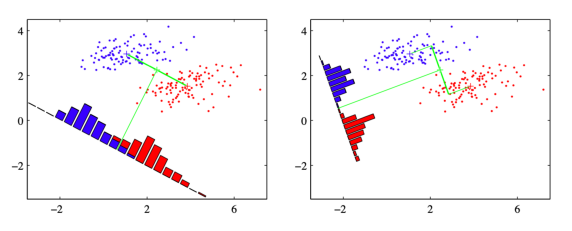

In [27]:
# 图4.6
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图4.6.png')
plt.axis('off')
ax.imshow(d)

它展示了在原来二维空间$ (x1, x2) $中可以完全分开的两个类别，当投影到连接它们的均值的直线上时，有一定程度的重叠。这是由于类别分布的协方差强非对角引起的。Fisher提出了最大化一种在给出大的投影均值的距离的同时，给出较小的每个类别内部的方差的函数的主意，来最小化类别重叠。


投影公式（4.20）把通过$ x $标记的数据点转换为通过一维空间$ y $标记的点。转换后的类别$ C_k $的内部方差由
$ s_k^2 = \sum\limits_{n \in C_k}(y_n - m_k)^2 \tag{4.24} $
其中$ y_n = w^Tx_n $。我们可以简单的定义整个数据集总的类别内部的方差为$ s_1^2 + s_2^2 $。Fisher准则是由类别间的方差与类别内部的方差比例定义的，即
$ J(w) = \frac{(m_2 - m_1)^2}{s_1^2 + s_2^2} \tag{4.25} $
使用式（4.20）、式（4.23）和式（4.24）对它重写得到
$ J(w) = \frac{w^TS_Bw}{w^TS_Ww} \tag{4.26} $
来显示的表达对$ w $的依赖。其中$ S_B $是类别间的写方差矩阵，由
$ S_B = (m_2 - m_1)(m_2 - m_1)^T \tag{4.27} $
给出，$ S_W $是总得类别内部方差矩阵，由
$ S_W = \sum\limits_{n \in C_1}(x_n - m_1)(x_n - m_1)^T + \sum\limits_{n \in C_2}(x_n - m_2)(x_n - m_2)^T \tag{4.28} $

In [28]:
# 重写

In [29]:
# 求导

对式（4.26）对于$ w $求导，得到当
$ (w^TS_Bw)S_Ww = (w^TS_Ww)S_Bw \tag{4.29} $
使得$ J(w) $最大。从式（4.27）我们得到$ S_Bw $总是在$ (m_2 - m_1) $的方向上。更重要的是我们只在乎$ w $的方向，而不在乎它的大小，因此我们可以去掉标量因子$ (w^TS_Bw) (w^TS_Ww) $。在式（4.29）两边都乘以$ S_W^{-1} $得到
$ w \propto S_W^{-1}(m_2 - m_1) \tag{4.30} $
注意，如果类别内部的协方差是各向同性的，那么$ S_W $正比于单位矩阵，然后得到和之前讨论的一样，$ w $正比于类均值的差。
尽管严格来说式（4.30）并不是一个判别式，而是对于数据向一维投影的方向的一个具体选择，但是仍习惯把它称为Fisher线性判别式。然而，投影的数据可以通过选择一个阈值$ y_0 $，使得当$ y(x) \geq y_0 $时，我们把它分到$ C_1 $中，否则把它分到$ C_2 $，来构造后面的判别式。例如，我们可以使用高斯概率分布对类条件密度$ p(y|C_k) $建模，然后使用1.2.4节的技术通过最大似然找到高斯分布的参数值。当找到投影类别的高斯近似之后，1.5.1节的方法给出了最优的阈值的形式化解。注意，$ y = w^Tx $是一组随机变量的和，因此根据中心极限定理，我们可以作出高斯分布的假设。



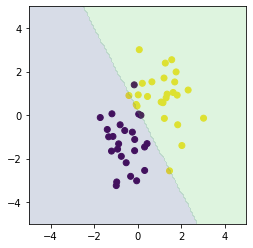

In [26]:
# Fisher
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

model = FishersLinearDiscriminant()
model.fit(x_train, y_train)
y = model.classify(x_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 4.3.2 Logstic回归

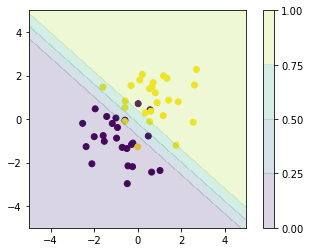

In [8]:
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = LogisticRegression()
model.fit(X_train, y_train)
y = model.proba(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 4.3.4 多类Logistic回归

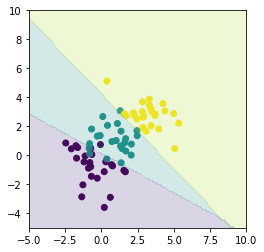

In [9]:
x_train, y_train = create_toy_data(add_class=True)
x1, x2 = np.meshgrid(np.linspace(-5, 10, 100), np.linspace(-5, 10, 100))
x = np.array([x1, x2]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X = feature.transform(x)

model = SoftmaxRegression()
model.fit(X_train, y_train, max_iter=1000, learning_rate=0.01)
y = model.classify(X)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1, x2, y.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 贝叶斯逻辑回归

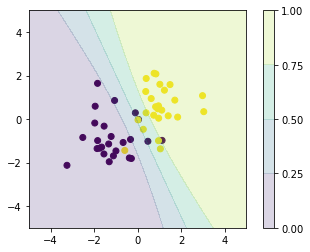

In [10]:
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = BayesianLogisticRegression(alpha=1.)
model.fit(X_train, y_train, max_iter=1000)
y = model.proba(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()